<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [20]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg
    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 12

Python Environment:
 | Python version: 3.10.13 (main, Aug 24 2023, 12:59:26) [Clang 15.0.0 (clang-1500.0.40.1)]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: None
 | CuGraph not installed, for better performance install it like this:
	pip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

Ressources:
 | CPU: 8 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
G = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


## Explorative Data Analysis

### Struktur der Daten
Die ICUJ Datenbank gibt uns bereits eine gute Visualisierung der Datenstruktur. Hier sehen wir die Edges zwischen den 4 wichtigsten Nodetypen (Node mit Typ Others wurden nicht berücksichtigt). Hier wurden jedoch aus Platzgründen nicht alle Kantenverbindungen oder Selfloops dargestellt:

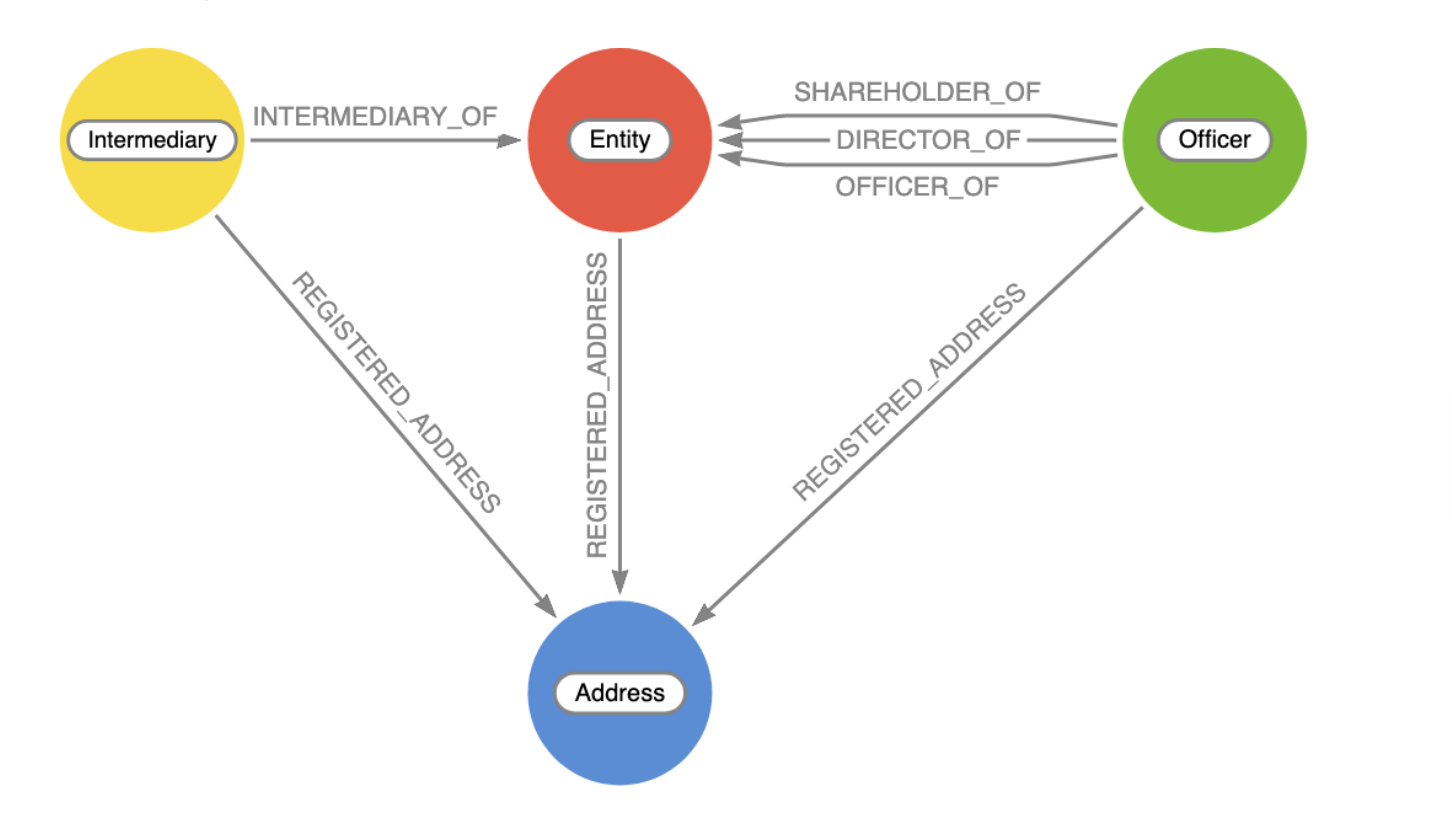

Es gibt einige Edges zwischen Intermediary und Officer, jedoch sind diese eher selten und nicht für unsere Analyse relevant. Die Verbindung zwischen Officer und Intermediary wird stattdessen über die Entity hergestellt.

### Note Types Bar Chart

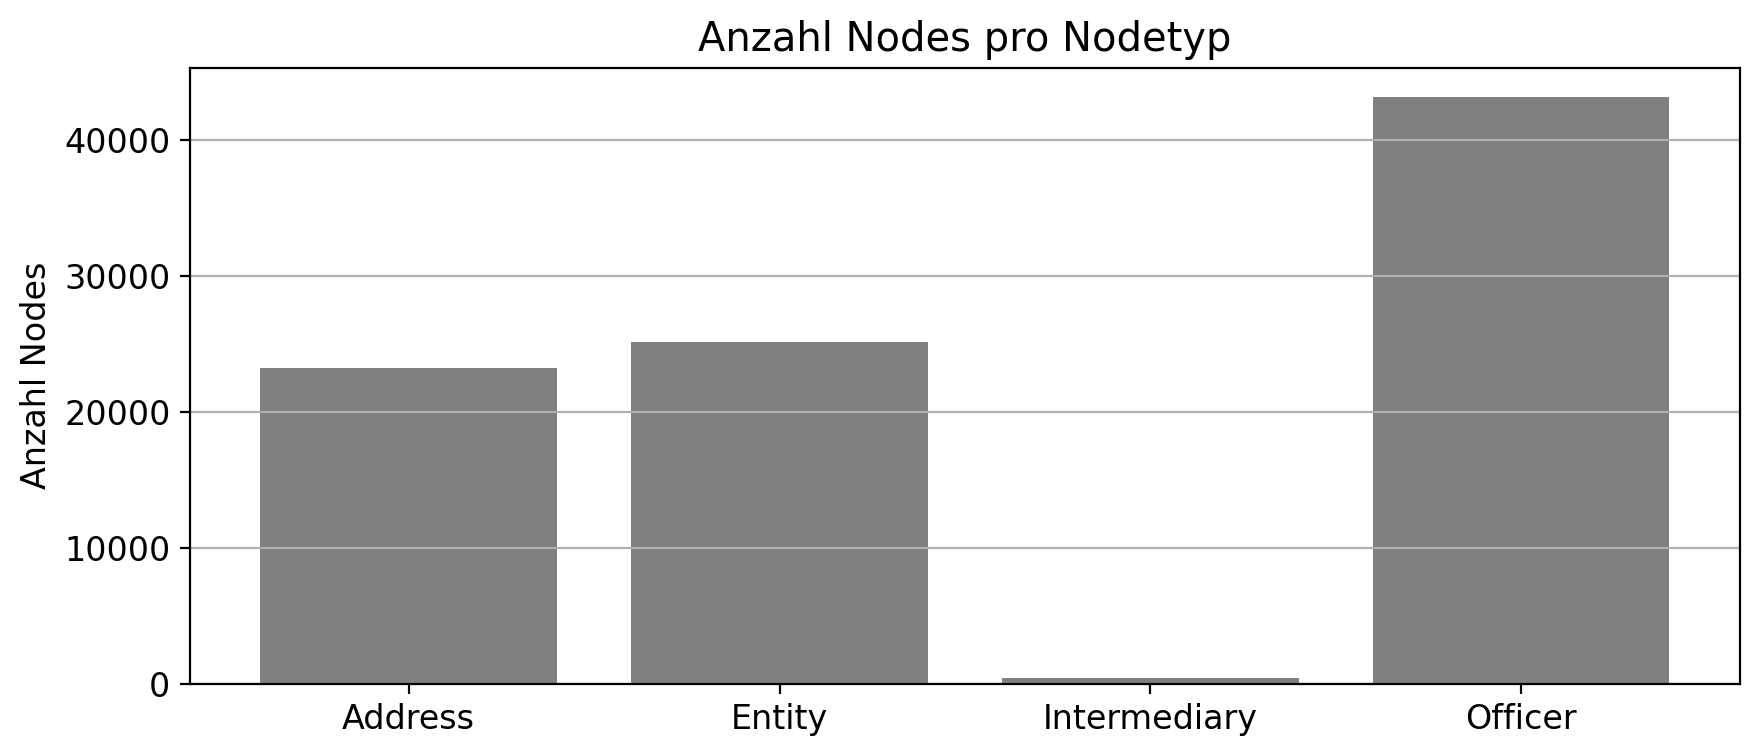

In [3]:
node_types = nx.get_node_attributes(G, "node_type").values()
unique_types, counts = np.unique(list(node_types), return_counts=True)

plt.bar(unique_types, counts, color="grey")
plt.title("Anzahl Nodes pro Nodetyp")
plt.ylabel("Anzahl Nodes")
plt.grid(axis="y")
plt.show()

Wir haben Verglichen zu den Officers recht wenig Entitäten. Dies weisst darauf hin, dass es durchschnittlich mehr als ein Officer pro Entität gibt. Es gibt auch sehr weniger Intermediaries als Officers. Sehr wahrscheinlich gibt es grosse Firmen, welche viele Offshore Firmen managen. Diese müssten wir genauer untersuchen. Es gibt auch recht wenige Addressen, entweder weil einige Officers, Entitäten oder Intermediaries keine Adresse haben oder weil mehrere Nodes die gleiche Adresse haben.

### Connected Components Size Distribution

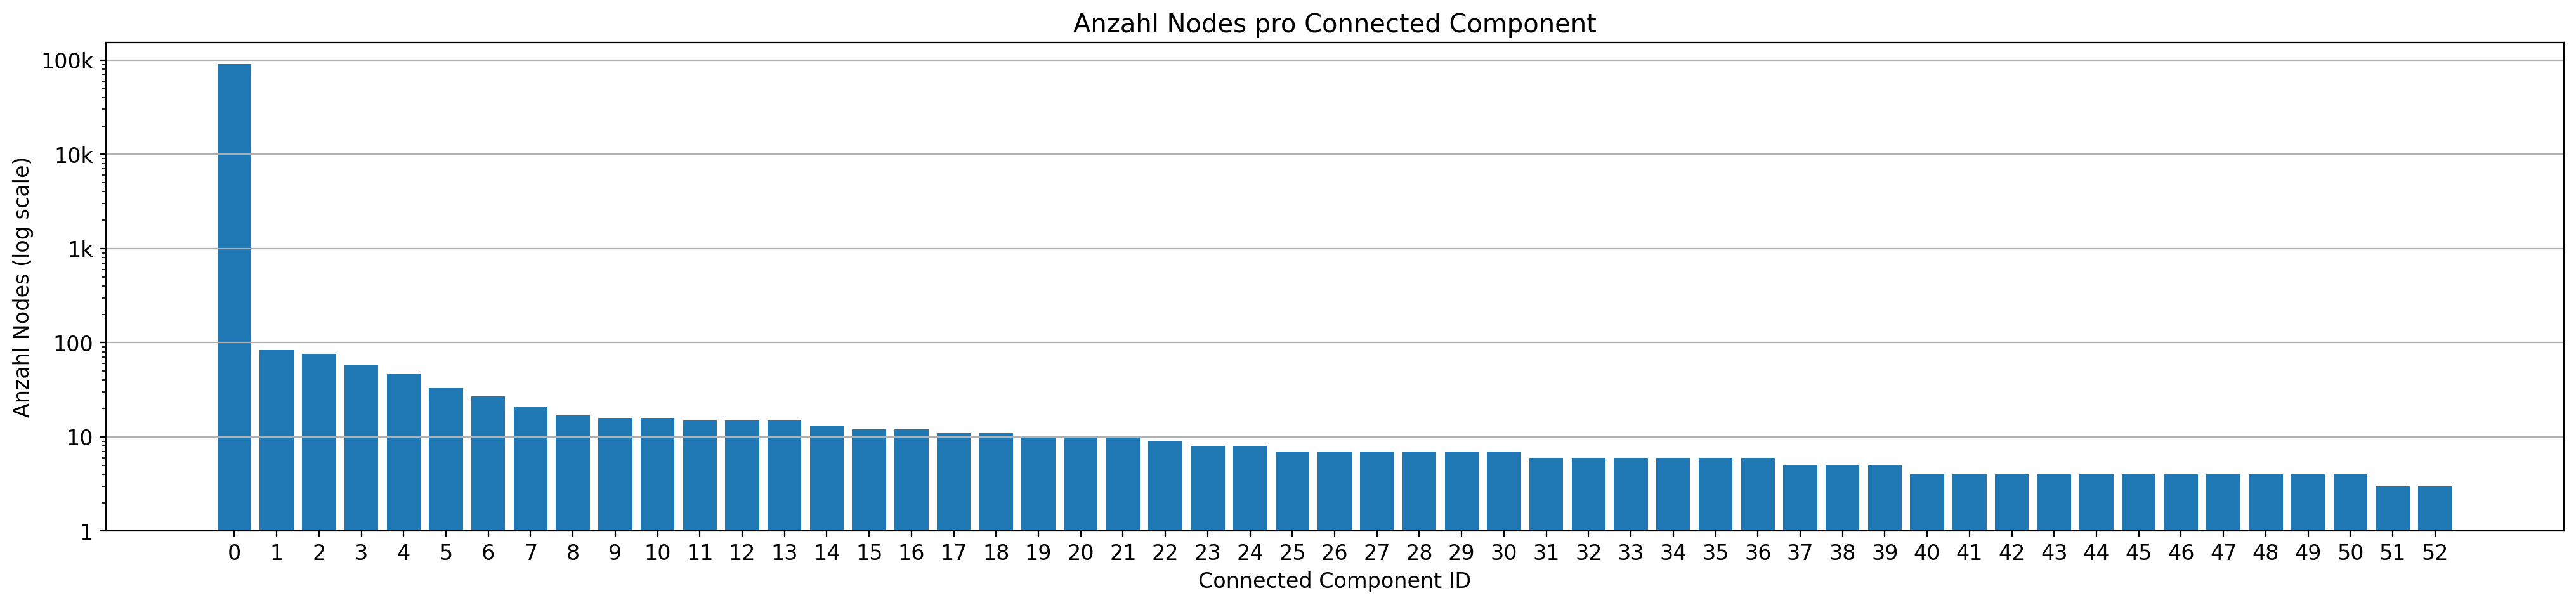

In [4]:
connected_components = np.array(
    list(
        sorted(
            nx.connected_components(G.to_undirected()), key=len, reverse=True
        )
    )
)

plt.figure(figsize=(25, 5))
plt.bar(range(len(connected_components)), [len(c) for c in connected_components])
plt.title("Anzahl Nodes pro Connected Component")
plt.ylabel("Anzahl Nodes (log scale)")
plt.xlabel("Connected Component ID")
plt.yscale("log")
plt.yticks([1, 10, 100, 1000, 10000, 100000], ["1", "10", "100", "1k", "10k", "100k"])
plt.xticks(range(len(connected_components)))
plt.grid(axis="y")
plt.show()

Es existiert ein grosser Component, welcher fast $10^5$ Nodes enthält. Der nächstgrösste Component enthält nur etwa $10^2$ Nodes.

### Netzwerkmetriken

#### Density

Density (Dichte) misst, wie nah ein Graph einem vollständigen Graphen ist, bei dem alle Knotenpaare verbunden sind. Sie wird berechnet als D = 2E / (N(N-1)), wobei E die Anzahl der Kanten und N die Anzahl der Knoten ist. Eine höhere Dichte zeigt mehr Kanten im Verhältnis zu den Knoten an, was auf ein stark vernetztes Netzwerk hinweist.

In [5]:
officer_graph = nx.bipartite.collaboration_weighted_projected_graph(
    nx.Graph(G),
    [node for node, data in G.nodes(data=True) if data["node_type"] == "Officer"],
)

In [6]:
officer_density = nx.density(officer_graph)
print(f"Officer Graph Density: {officer_density:.6f}")

Officer Graph Density: 0.000331


In [7]:
available_countries = np.array(
    [country for node, data in G.nodes(data=True) for country in data["countries"].split(";")]
)

available_country_codes = np.array(
    [country for node, data in G.nodes(data=True) for country in data["country_codes"].split(";")]
)

# filter available_country_codes from available_countries
available_countries = np.array(
    [country for country in available_countries if country not in available_country_codes]
)

# add counts for available_countries
available_countries, counts = np.unique(available_countries, return_counts=True)
available_countries = zip(available_countries, counts)
available_countries = sorted(available_countries, key=lambda x: x[1], reverse=True)

Average Officer Graph Density: 0.013309


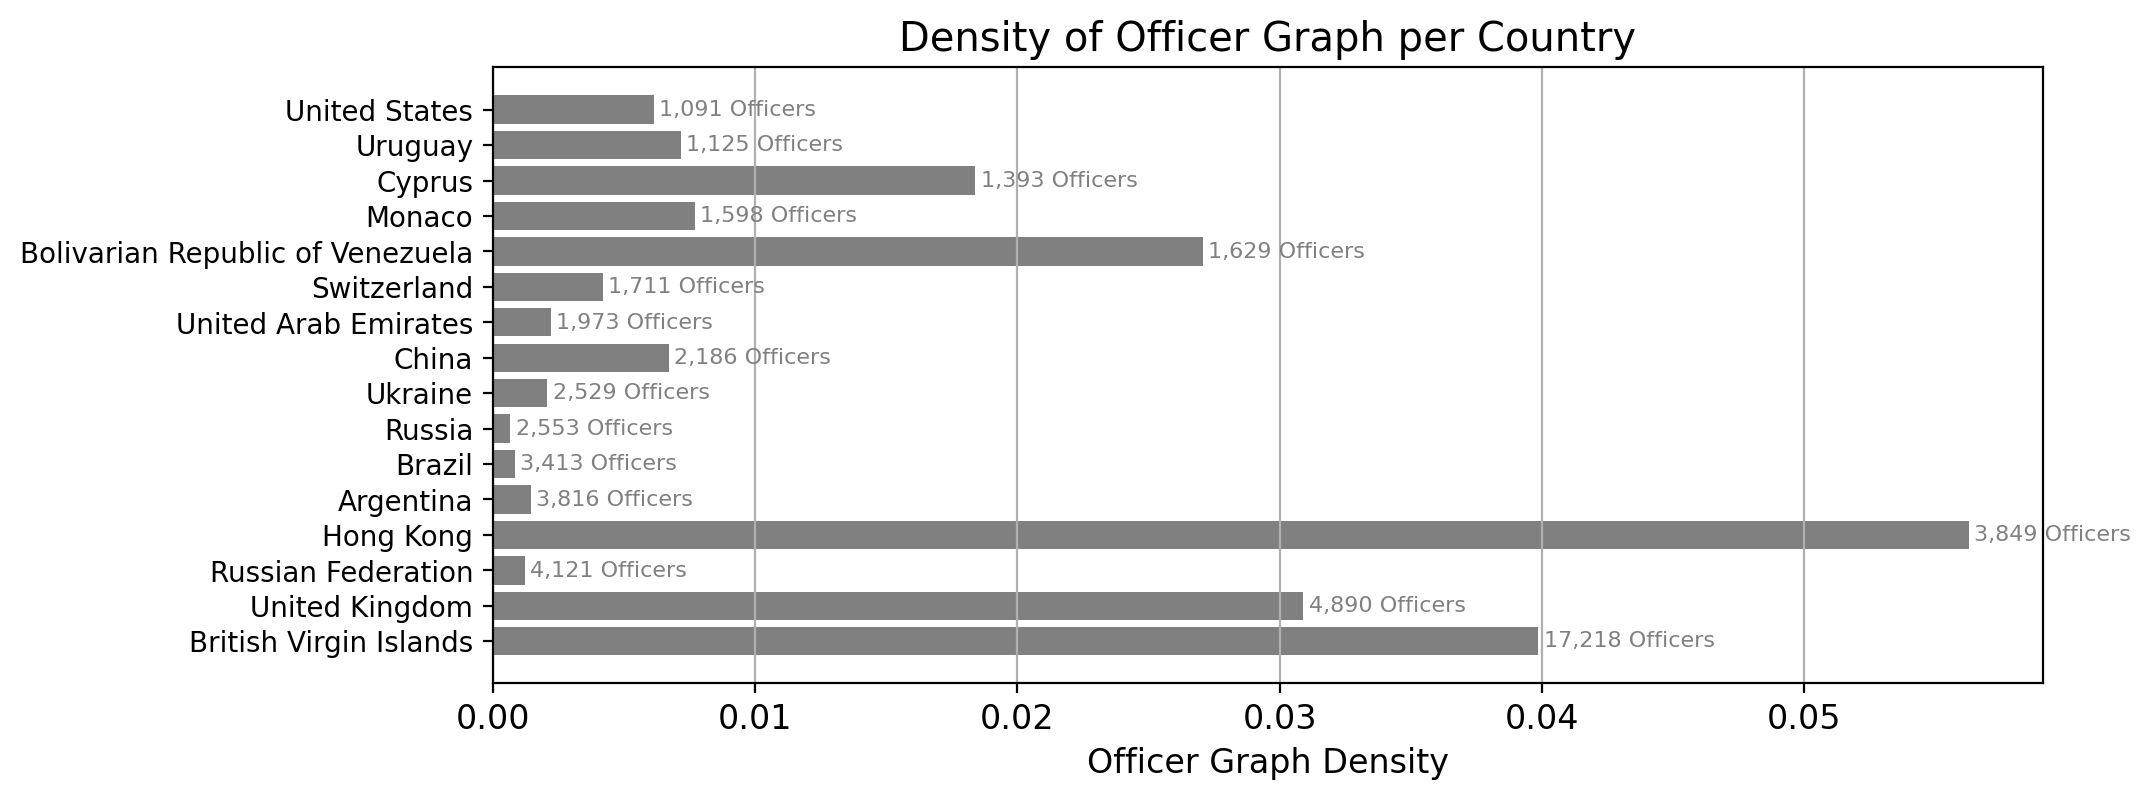

In [17]:
countries = []
counts = []
densities = []

for country, count in available_countries:
    if count > 1000:
        countries.append(country)
        counts.append(count)
        density = nx.density(officer_graph.subgraph([node for node in officer_graph.nodes if utils.is_officer_from_country_name(G, node, country)]))
        densities.append(density)

print(f"Average Officer Graph Density: {np.mean(densities):.6f}")

plt.barh(countries, densities, color="grey")
plt.title("Density of Officer Graph per Country")
plt.xlabel("Officer Graph Density")
for i, (country, density) in enumerate(zip(countries, densities)):
    plt.text(density + 0.0002, i, f"{counts[i]:,} Officers", va="center", ha="left", fontsize=8, color="grey")
plt.yticks(fontsize=10)
plt.grid(axis="x")
plt.show()

Schweizer Officer scheinen, im Vergleich zu den anderen Ländern mit über 1000 Officers in unserem Datensatz, nicht allzu stark mtieinander vernetzt zu sein.

#### Group Centrality

Gruppenzentralität misst die Wichtigkeit einer Gruppe von Knoten in einem Netzwerk. Sie bewertet, wie zentral die Gruppe im Gesamtnetzwerk ist, basierend auf verschiedenen Zentralitätsmaßen wie Degree, Closeness oder Betweenness. Degree-Zentralität betrachtet die Anzahl der direkten Verbindungen eines Knotens, während Closeness-Zentralität bewertet, wie kurz die durchschnittlichen Distanzen eines Knotens zu allen anderen Knoten sind. Eine hohe Gruppenzentralität zeigt, dass die Knotengruppe eine Schlüsselrolle in der Kommunikation oder im Informationsfluss des Netzwerks spielt.

In [22]:
degree_centralities = []
closeness_centralities = []

for country in tqdm(countries):
    global_view_G, global_view_node = utils.global_view(G, [("countries", country)])
    degree_centralities.append(nx.degree_centrality(global_view_G)[global_view_node])
    closeness_centralities.append(nx.closeness_centrality(global_view_G)[global_view_node])

  0%|          | 0/16 [00:00<?, ?it/s]

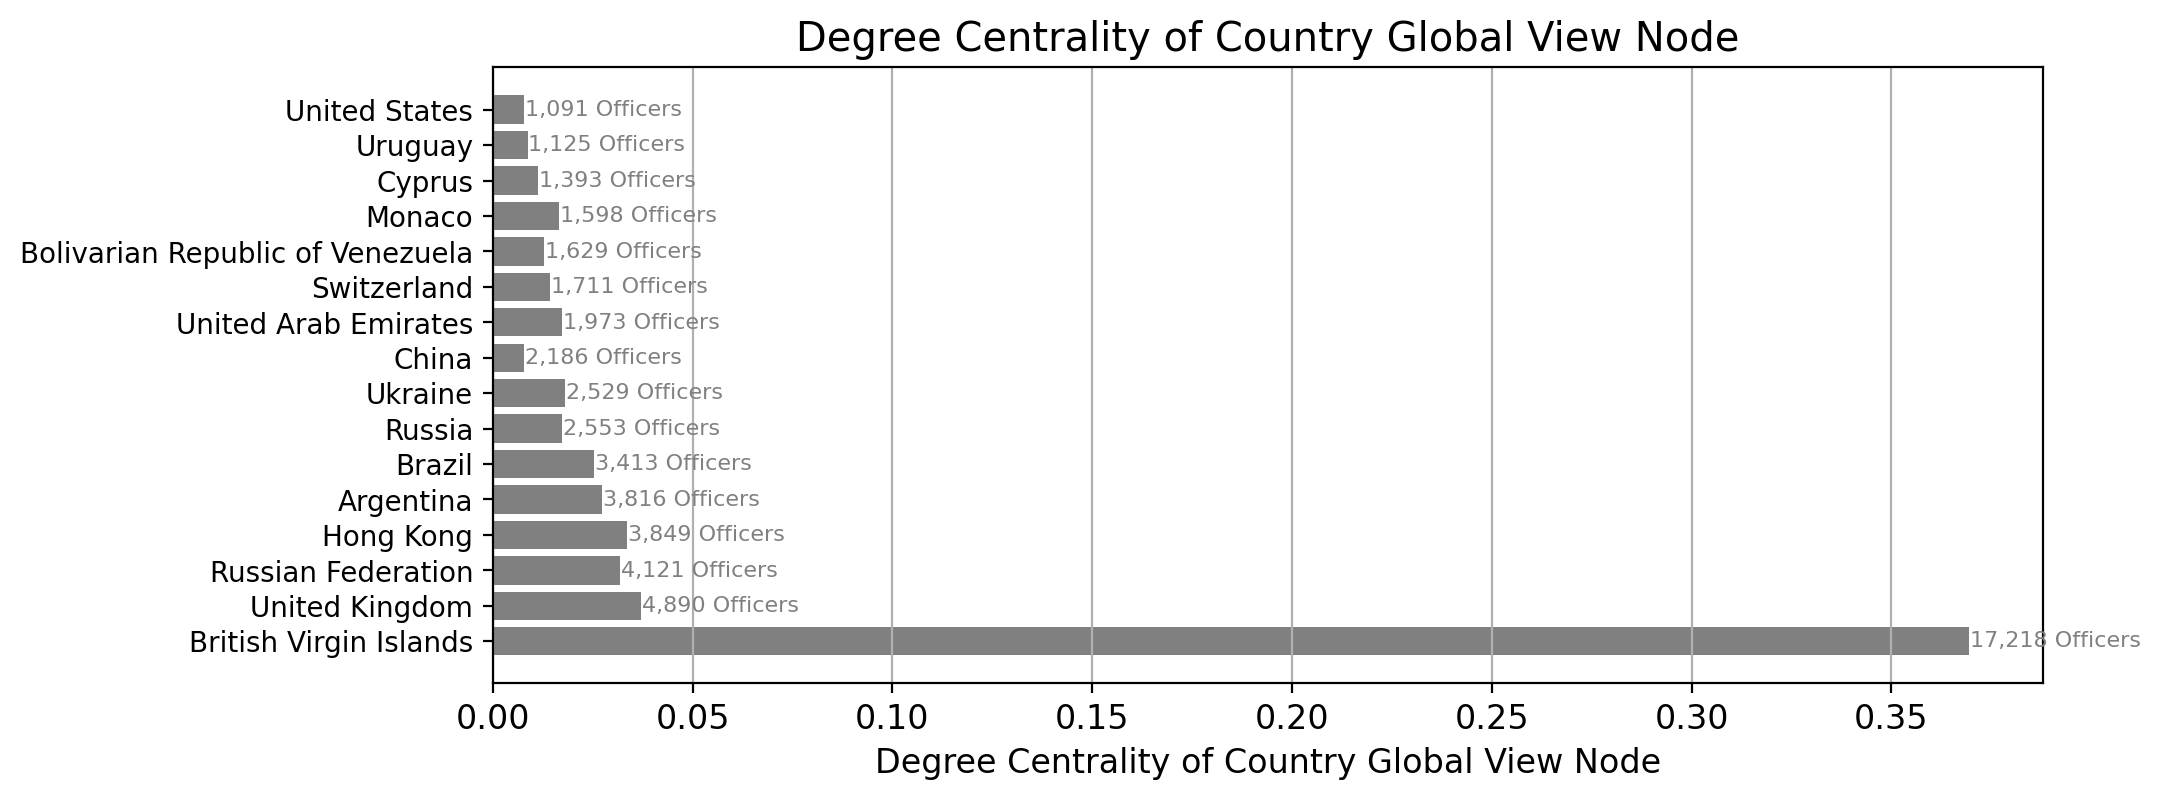

In [23]:
plt.barh(countries, degree_centralities, color="grey")
plt.title("Global View Degree Centrality per Country")
plt.xlabel("Degree Centrality of Country Global View Node")
for i, (country, degree) in enumerate(zip(countries, degree_centralities)):
    plt.text(degree + 0.0002, i, f"{counts[i]:,} Officers", va="center", ha="left", fontsize=8, color="grey")
plt.yticks(fontsize=10)
plt.grid(axis="x")
plt.show()

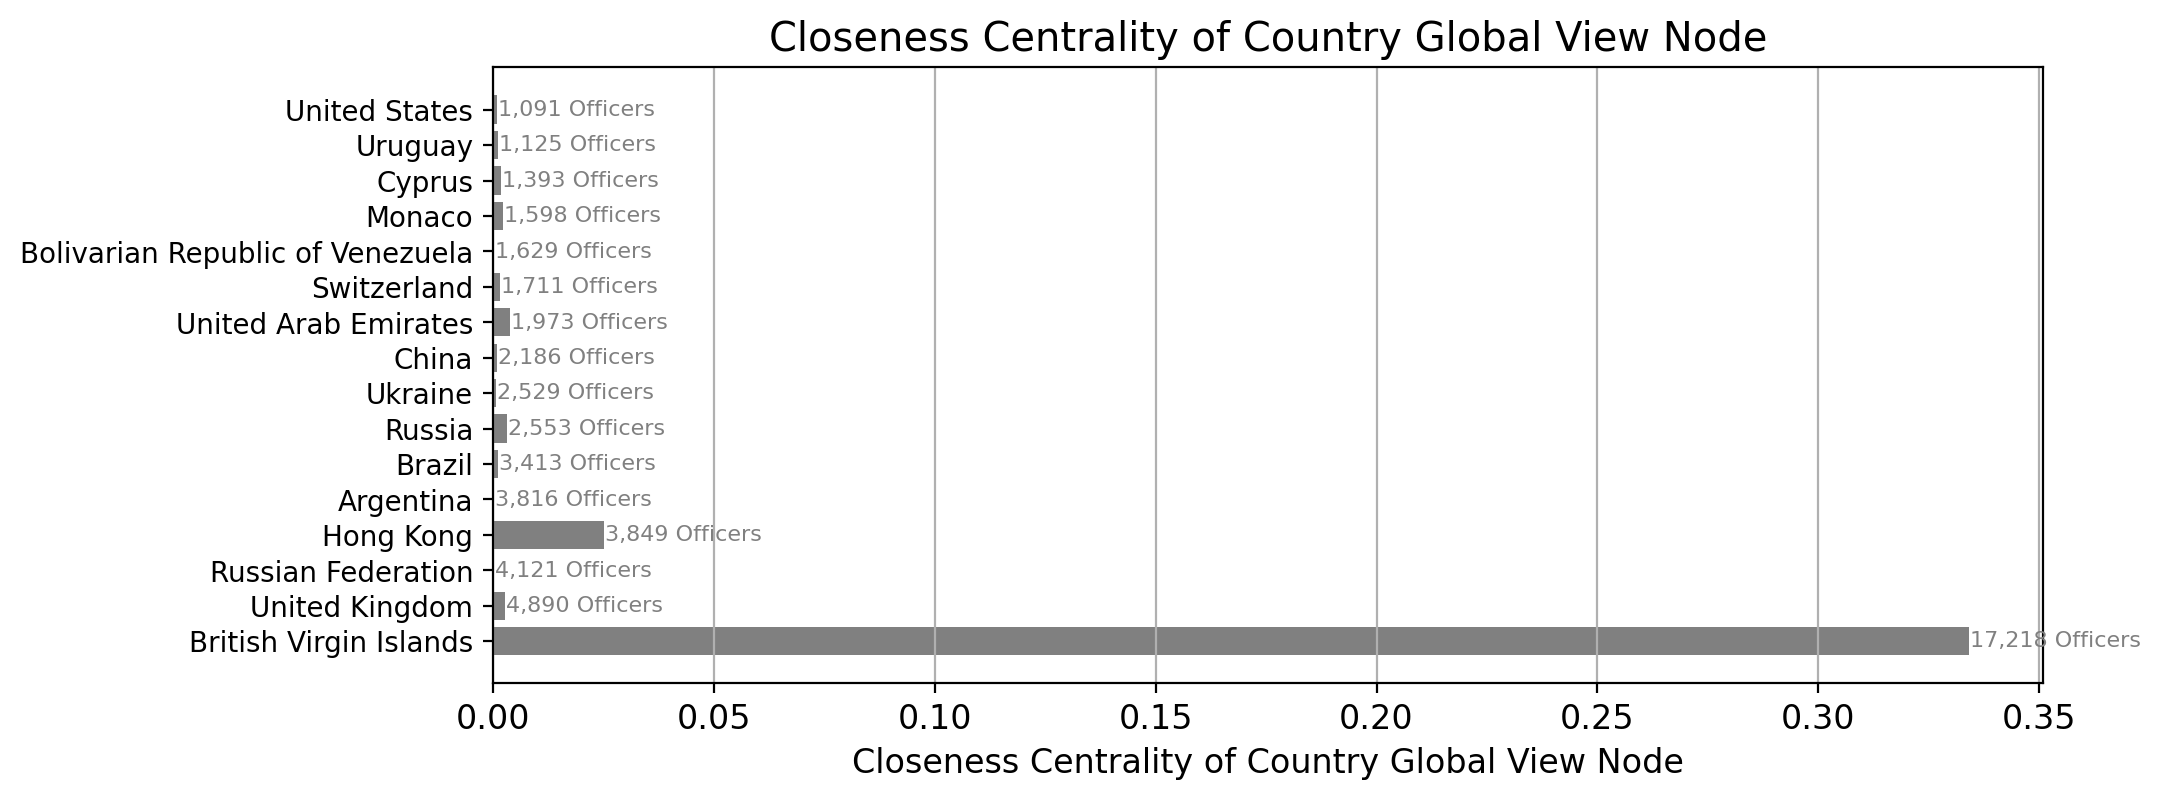

In [24]:
plt.barh(countries, closeness_centralities, color="grey")
plt.title("Global View Closeness Centrality per Country")
plt.xlabel("Closeness Centrality of Country Global View Node")
for i, (country, degree) in enumerate(zip(countries, closeness_centralities)):
    plt.text(degree + 0.0002, i, f"{counts[i]:,} Officers", va="center", ha="left", fontsize=8, color="grey")
plt.yticks(fontsize=10)
plt.grid(axis="x")
plt.show()

Hier scheinen die Schweiz Officers im Vergleich zu den anderen Ländern nicht besonders Zentral zu sein. Besonders die British Virgin Islands scheinen im Vergleich zu den anderen Ländern sehr zentral zu sein.